# Classification: Data Modeling

In [1]:
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from os.path import exists

from scipy.stats import uniform

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

## Section 1: Term weighting with TF-IDF

In [2]:
target = 'tweets.csv'
supervised_target_path = f'../dataset/processed/supervised_{target}'

In [3]:
df = pd.read_csv(supervised_target_path, delimiter=';')
df.dropna(inplace=True)

df.head()

,content,tokens,tokens_ready,text,polarity,sentiment
0,@soeyoto1 @msaid_didu Bukti kalau Pemerintahan...,"['bukti', 'pemerintahan', 'pro', 'rakyat', 'pr...","['bukti', 'perintah', 'pro', 'rakyat', 'pro', ...",bukti perintah pro rakyat pro oligarki bbmnya ...,-2,0
1,"@KompasTV Mentri esdm, trus patokanmu apa? Kan...","['menteri', 'esdm', 'patokanmu', 'kantong', 'j...","['menteri', 'esdm', 'patok', 'kantong', 'jebol...",menteri esdm patok kantong jebol korupsi imbas...,-9,0
2,@hnurwahid Ngaku masih subsidi tapi ada swasta...,"['mengaku', 'subsidi', 'swasta', 'jual', 'mura...","['subsidi', 'swasta', 'jual', 'murah', 'subsid...",subsidi swasta jual murah subsidi pimpin tukan...,6,1
3,@Tan_Mar3M Kalau Vivo bisaberani bertahan deng...,"['berani', 'bertahan', 'harga', 'nasib']","['berani', 'tahan', 'harga', 'nasib']",berani tahan harga nasib,4,1
4,Menteri BUMN Erick Thohir menegaskan persiapan...,"['menteri', 'bumn', 'erick', 'thohir', 'persia...","['menteri', 'bumn', 'erick', 'thohir', 'indone...",menteri bumn erick thohir indonesia transisi e...,2,1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=687)

In [5]:
vectorizer = TfidfVectorizer(use_idf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [6]:
def random_best_search_param():
  param_grid = {'C': uniform(loc=0, scale=4),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': uniform(loc=0, scale=0.1)}
  svm_model = svm.SVC()
  grid_search = RandomizedSearchCV(svm_model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, random_state=0, verbose=1)
  grid_search.fit(X_train_tfidf, y_train)

  with open("../dataset/model/svm_best_params.pkl", "wb") as f:
    pickle.dump(grid_search.best_params_, f)

  print("Best parameters: ", grid_search.best_params_)
  print("Best score: ", grid_search.best_score_)
  
  return grid_search.best_params_

def load_svm_best_param():
	try:
		with open('../dataset/model/svm_best_params.pkl', 'rb') as f:
			return pickle.load(f)
	except FileNotFoundError:
		return None

def load_svm_model():
    model_path = '../dataset/model/svm_model.pkl'
    svm_model = None

    if exists(model_path):
      with open(model_path, 'rb') as f:
        svm_model = pickle.load(f)
    else:
      best_params = load_svm_best_param()
      if best_params is None:
        best_params = random_best_search_param()
      svm_model = svm.SVC(**best_params)
    
    svm_model.fit(X_train_tfidf, y_train)
    svm_model.score(X_test_tfidf, y_test)

    return svm_model

In [7]:
# load svm model
svm_model = load_svm_model()

y_pred = svm_model.predict(X_test_tfidf)

In [8]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print('\n Report : ') 
print(classification_report(y_test, y_pred))

Accuracy: 0.8686440677966102
Precision: 0.907626208378088
Recall: 0.8941798941798942
F1-Score: 0.9008528784648188

 Report : 
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       471
           1       0.91      0.89      0.90       945

    accuracy                           0.87      1416
   macro avg       0.85      0.86      0.85      1416
weighted avg       0.87      0.87      0.87      1416



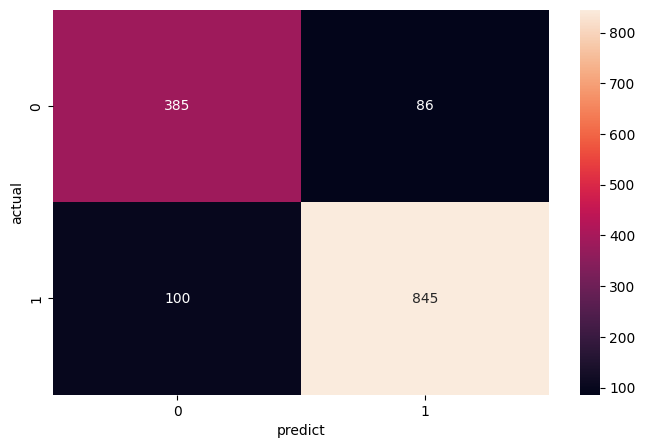

In [9]:
# visualize confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", ax=ax)
plt.xlabel("predict")
plt.ylabel("actual")
plt.show()

In [10]:
# Results from prediction sentiment on data test

texts = df['text']
text_train, text_test = train_test_split(texts, test_size=0.2, random_state=687)

result_test = pd.DataFrame(data=zip(text_test, y_pred), columns=['text', 'polarity'])

polarity_decode = {0 : 'Negative', 1 : 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)

pd.set_option('max_colwidth', 300)
result_test.sample(10)

,text,polarity
1293,galang dana,Positive
526,jokowi presiden nya ahok bedua susah rakyat,Positive
315,duuhhh pantesan bangkrut hitung banding ngaco gitu,Negative
1321,persetan monopoli,Positive
1188,aipda sasmito heri patroli monitoring pantau spbu wilkum polsek kramatjati lokasi spbu raya dwi sartika kel cililitan kec kramatjati hasil giat pantau jenis bbm pertalite sedia solar sedia pertamax sedia,Positive
563,selamat,Positive
271,hitung hpp pertalite kayak gimana case jual ron harga jual nyari untung jual ron subsidi ngakunya rugi,Positive
862,gaji orang wkwk,Positive
184,bagus gitu bbm orang nyantai iya salah nikmat bbm subsidi,Positive
1105,takut efek domino kenyataanya ulang kali ekonomi buruk takut makan makan,Positive


In [11]:
# save model
with open('../dataset/model/sental_model.pkl', 'wb') as f:
	pickle.dump(svm_model, f)

# save vectorizer
with open('../dataset/model/vectorizer.pkl', 'wb') as f:
	pickle.dump(vectorizer, f)

In [12]:
sample_text = 'Kami Mendukung Keputusan PemeRintah untUk menAIkkan HARga BBM'

sample_text = vectorizer.transform([sample_text])
result = svm_model.predict(sample_text)

sentiment = polarity_decode[result[0]]
print(sentiment)

Positive
